# Introduction à `Python` - *correction*


In [1]:
import pandas

In [2]:
from matplotlib import pyplot as plt
import seaborn

%matplotlib inline

In [3]:
import requests

In [4]:
import folium

## A faire

- Ecrire le code permettant d'importer les informations de toutes les stations et stocker celles-ci dans un data frame `pandas`

In [5]:
url = "https://opendata.paris.fr/api/records/1.0/search/"
dataset = "velib-disponibilite-en-temps-reel"
# récupération du nombre de stations
r = requests.get(url = url, params = dict(dataset = dataset)).json()
# récupération de tout
df = pandas.DataFrame([s["fields"] for s in requests.get(url = url, params = dict(dataset = dataset, rows = r['nhits'])).json()['records']])
df.head()

,name,stationcode,ebike,mechanical,coordonnees_geo,duedate,numbikesavailable,numdocksavailable,capacity,is_renting,is_installed,nom_arrondissement_communes,is_returning
0,Charonne - Robert et Sonia Delauney,11104,2,0,"[48.85590755596891, 2.3925706744194035]",2022-04-11T14:34:51+00:00,2,18,20,OUI,OUI,Paris,OUI
1,Toudouze - Clauzel,9020,3,1,"[48.87929591733507, 2.3373600840568547]",2022-04-11T14:33:25+00:00,4,17,21,OUI,OUI,Paris,OUI
2,Mairie du 12ème,12109,1,3,"[48.84085531176338, 2.3875549435615544]",2022-04-11T14:36:16+00:00,4,25,30,OUI,OUI,Paris,OUI
3,Harpe - Saint-Germain,5001,3,38,"[48.85151881501689, 2.343670316040516]",2022-04-11T14:38:09+00:00,41,3,45,OUI,OUI,Paris,OUI
4,Cassini - Denfert-Rochereau,14111,0,1,"[48.83752583906732, 2.336035408079624]",2022-04-11T14:30:53+00:00,1,24,25,OUI,OUI,Paris,OUI


- Représenter la distribution des capacités (`capacity`) des stations

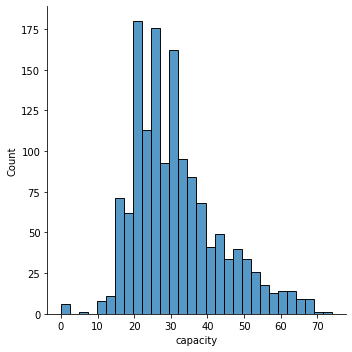

In [6]:
seaborn.displot(data = df, x = "capacity")

<AxesSubplot:xlabel='capacity'>

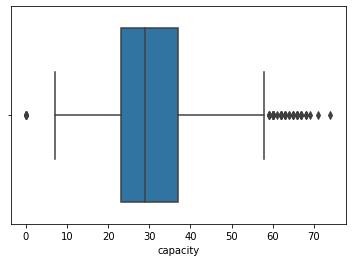

In [7]:
seaborn.boxplot(data = df, x = "capacity")

- Faire de même en comparant les villes

<AxesSubplot:xlabel='capacity', ylabel='nom_arrondissement_communes'>

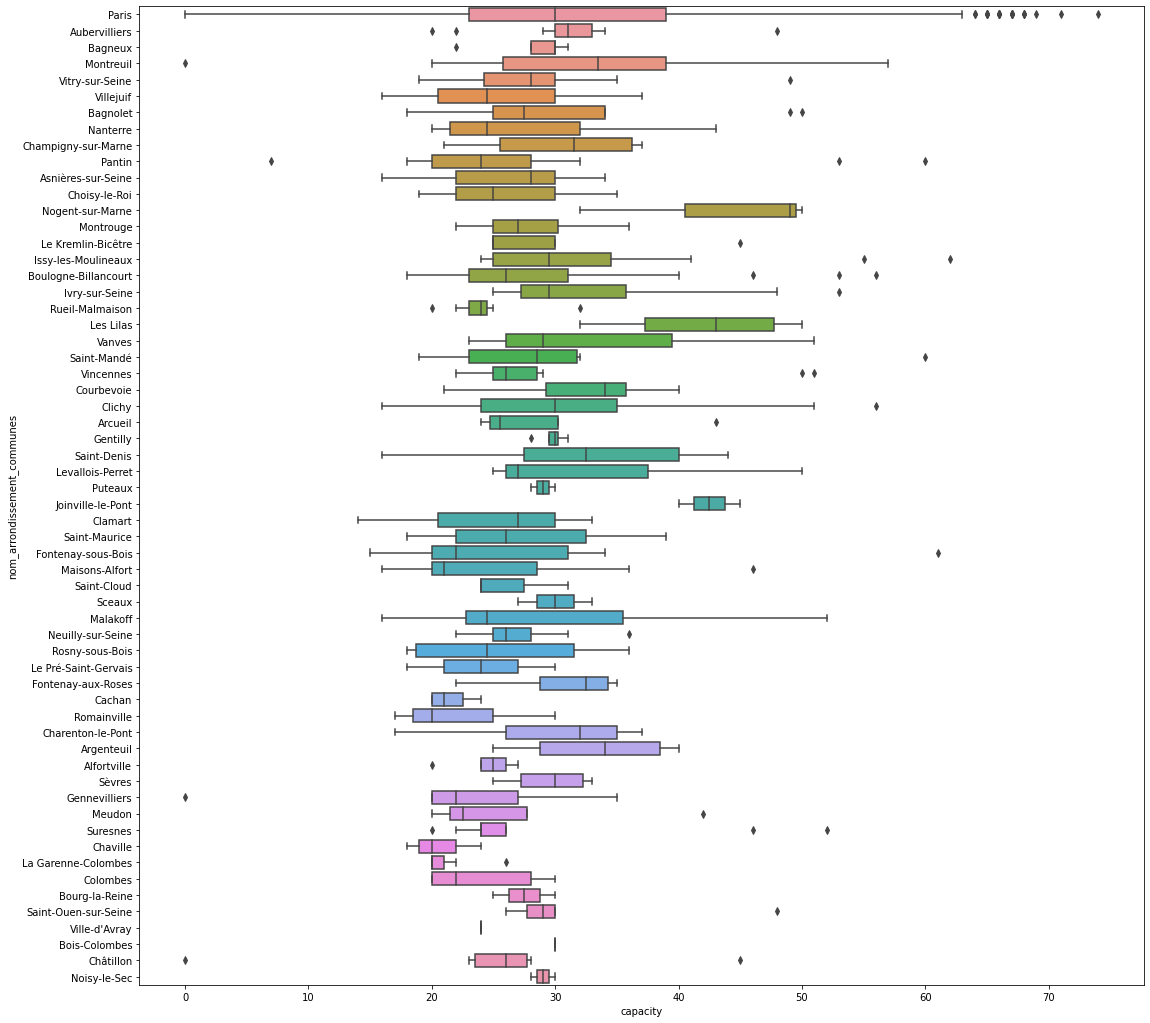

In [8]:
plt.figure(figsize=(18,18))
seaborn.boxplot(data = df, x = "capacity", y = "nom_arrondissement_communes")

- Afficher les stations sur une carte

In [9]:
def popup(station):
    msg = "<strong>" + station["name"] + "</strong>"\
        + " (" + station["nom_arrondissement_communes"] + ")"
    return msg

centre = [48.87, 2.35]
paris = folium.Map(location = centre, zoom_start = 11)

for st in range(df.shape[0]):
    station = df.iloc[st,:]
    # print(popup(station))
    folium.Marker(station["coordonnees_geo"],
                  tooltip = station["name"],
                  popup = popup(station)).add_to(paris)
paris

- Pour chaque ville (`nom_arrondissement_communes`), calculer :
    - le nombre de stations
    - le nombre total de places (`capacity`)
    - le nombre total de vélos disponibles (`numbikesavailable`)
    - le nombre total de places disponibles (`numdocksavailable`) 
    - les coordonnées moyennes (pour permettre un affichage)

In [10]:
ag_count = df.filter(["nom_arrondissement_communes", "capacity"])\
    .groupby("nom_arrondissement_communes")\
    .count()\
    .rename(columns = {"capacity": "nbStations"})
ag_count.head()

,nbStations
nom_arrondissement_communes,
Alfortville,5
Arcueil,4
Argenteuil,4
Asnières-sur-Seine,9
Aubervilliers,13


In [11]:
ag_sum = df.filter(["nom_arrondissement_communes", "capacity", "numbikesavailable", "numdocksavailable"])\
    .groupby("nom_arrondissement_communes")\
    .aggregate(["sum"])\
    .droplevel(level = 1, axis = 1)\
    .rename(columns = {"capacity": "capacité", "numbikesavailable": "vélosDispo",
                       "numdocksavailable": "placesDispo"})
ag_sum.head()

,capacité,vélosDispo,placesDispo
nom_arrondissement_communes,,,
Alfortville,122,81,37
Arcueil,118,24,94
Argenteuil,133,61,71
Asnières-sur-Seine,236,59,169
Aubervilliers,404,155,242


In [12]:
ag_mean = df.filter(["nom_arrondissement_communes"])\
    .assign(lat = [c[0] for c in df["coordonnees_geo"]])\
    .assign(lng = [c[1] for c in df["coordonnees_geo"]])\
    .groupby("nom_arrondissement_communes")\
    .aggregate(["mean"])\
    .droplevel(level = 1, axis = 1)
ag_mean.head()

,lat,lng
nom_arrondissement_communes,,
Alfortville,48.801567,2.422036
Arcueil,48.806420,2.331766
Argenteuil,48.947095,2.241625
Asnières-sur-Seine,48.914764,2.287231
Aubervilliers,48.910740,2.381001


In [13]:
ag_final = pandas.concat([ag_count, ag_sum, ag_mean], axis = 1)
ag_final.head()

,nbStations,capacité,vélosDispo,placesDispo,lat,lng
nom_arrondissement_communes,,,,,,
Alfortville,5,122,81,37,48.801567,2.422036
Arcueil,4,118,24,94,48.806420,2.331766
Argenteuil,4,133,61,71,48.947095,2.241625
Asnières-sur-Seine,9,236,59,169,48.914764,2.287231
Aubervilliers,13,404,155,242,48.910740,2.381001


- Afficher un marqueur pour chaque ville (positionné au centre des stations de celle-ci), avec les informations récupérées ci-dessous

In [14]:
def popup_ville(ville):
    msg = "<strong>" + ville.name + "</strong><ul>"\
        + "<li>Nombre de stations : " + str(ville["nbStations"]) + "</li>"\
        + "<li>Capacité totale : " + str(ville["capacité"]) + "</li>"\
        + "<li>Vélos disponibles : " + str(ville["vélosDispo"]) + "</li>"\
        + "<li>Places disponibles : " + str(ville["placesDispo"]) + "</li></ul>"
    iframe = folium.IFrame(msg)
    popup = folium.Popup(iframe,
                     min_width = 300,
                     max_width = 300)
    return popup

centre = [48.87, 2.35]
carte_ville = folium.Map(location = centre, zoom_start = 11)

for v in range(ag_final.shape[0]): #
    ville = ag_final.iloc[v,:]
    folium.Marker([ville.lat, ville.lng],
                  tooltip = ville.name,
                  popup = popup_ville(ville)).add_to(carte_ville)
carte_ville